# Task (2) STOCK PREDICTION USING LSTM

## Importing libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

## Data Loading

 Using the Microsoft Corporation (MSFT)  stock data here... 

In [40]:
data = yf.download('MSFT', start='2015-01-01', end='2023-01-01')         # Microsoft Corporation (MSFT)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.305367,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,39.934727,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,39.348591,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,39.848530,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.020798,29645200
...,...,...,...,...,...,...
2022-12-23,236.110001,238.869995,233.940002,238.729996,235.769760,21207000
2022-12-27,238.699997,238.929993,235.830002,236.960007,234.021729,16688600
2022-12-28,236.889999,239.720001,234.169998,234.529999,231.621841,17457100


## Overview of data

In [41]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.305367,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,39.934727,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,39.348591,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,39.848530,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.020798,29645200


In [23]:
data.shape

(2014, 6)

In [42]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [43]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2014 non-null   float64
 1   High       2014 non-null   float64
 2   Low        2014 non-null   float64
 3   Close      2014 non-null   float64
 4   Adj Close  2014 non-null   float64
 5   Volume     2014 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.1 KB


In [44]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2.014000e+03
mean,142.891589,144.332890,141.375621,142.925526,136.966341,3.006624e+07
std,88.663667,89.637932,87.601820,88.663042,88.523067,1.385974e+07
min,40.340000,40.740002,39.720001,40.290001,34.823284,7.425600e+06
25%,62.707500,63.127500,62.312499,62.685000,57.026097,2.153742e+07
50%,110.139999,111.254997,108.919998,110.225002,103.984077,2.676495e+07
75%,222.027496,224.195000,219.130005,221.609993,215.779388,3.424465e+07
max,344.619995,349.670013,342.200012,343.109985,335.709839,1.691640e+08


## Plotting the close price history

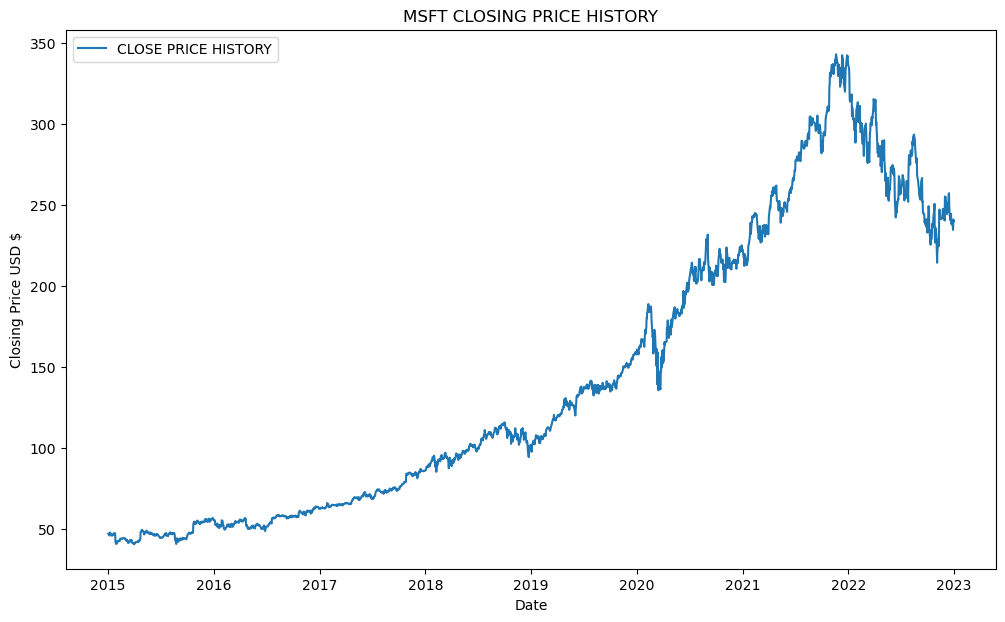

In [45]:
plt.figure(figsize=(12, 7))
plt.plot(data['Close'], label='CLOSE PRICE HISTORY')
plt.title('MSFT CLOSING PRICE HISTORY')
plt.xlabel('Date')
plt.ylabel('Closing Price USD $')
plt.legend()
plt.show()

## Preparing the data for (LSTM model)

In [46]:
data = data['Close'].values
data = data.reshape(-1, 1)
 
scaler = MinMaxScaler(feature_range=(0, 1))                           # Scaling the data
scaled_data = scaler.fit_transform(data)

## Create the training data set

In [47]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]

test_data = scaled_data[train_size:]    

## Create the training and testing data in (time-series format)

In [48]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

## Reshaping of training data

In [49]:
X_train, y_train = create_dataset(train_data)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

## Reshaping of testing data

In [50]:
X_test, y_test = create_dataset(test_data)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Now build the LSTM Model

In [51]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Users\Chohan\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the Model

In [32]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

## Train the Model

In [33]:
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - loss: 0.0194
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - loss: 2.9078e-04
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - loss: 2.0447e-04
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 1.8485e-04
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - loss: 1.8954e-04
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 340ms/step - loss: 2.1697e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - loss: 2.1411e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - loss: 2.7605e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - loss: 2.0868e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - loss: 1.7433e-04


## Model's Prediction on test data

In [34]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step


In [35]:
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))                    # Getting the actual prices

## Plotting the predictions against the actual prices

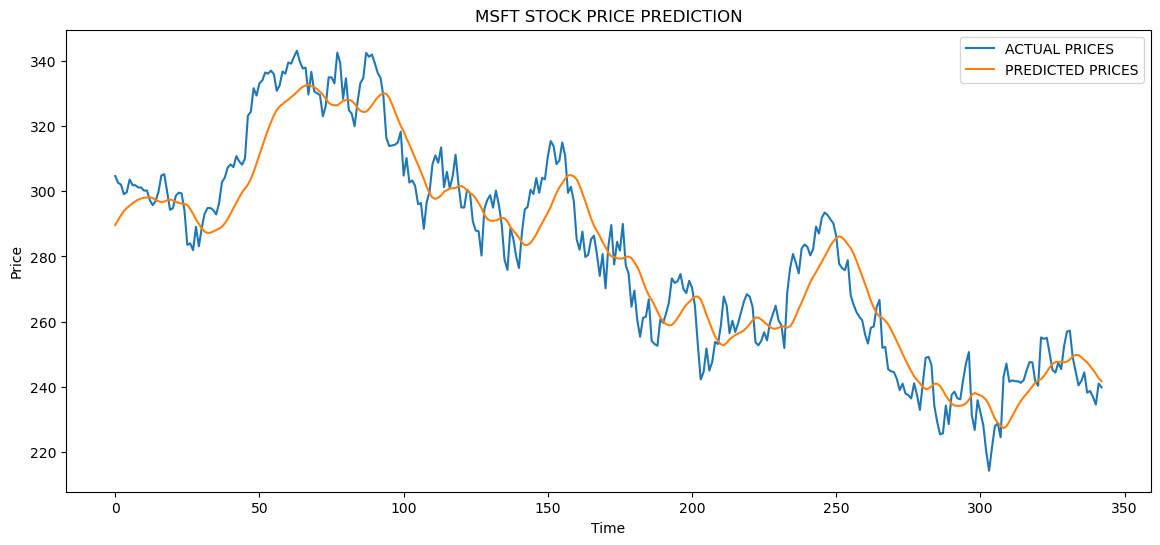

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='ACTUAL PRICES')
plt.plot(predictions, label='PREDICTED PRICES')
plt.title('MSFT STOCK PRICE PREDICTION')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()